In [1]:
import os
from collections import defaultdict as dd
import numpy as np
from scipy import stats as st
from matplotlib import pyplot as plt

# read data

In [2]:
mats = {
    "a": dd(int),
    "c": dd(int),
    "f": dd(int)
}

with os.scandir("./data/labeled_sanitized/") as directory:
    for entry in directory:
        if entry.is_file():
            print(f"reading {entry.name}...")
            with open(entry.path) as file:
                for i, line in enumerate(file.readlines()):
                    if i > 6:
                        idx = i % 7
                        if idx == 2:
                            id_l = line[1:line.index(')')]
                        elif idx == 3:
                            id_r = line[1:line.index(')')]
                        elif idx == 4:
                            if line == 'Y\n':
                                label = 0
                            elif line == 'N\n':
                                label = 1
                            else:
                                raise ValueError(f"invalid label: '{line}'")
                            pair = (int(id_l[1:]), int(id_r[1:]))
                            mats[id_l[0]][pair] += label

for mat in mats.values():
    for key in mat:
        mat[key] /= 3

reading set_1.txt...
reading set_2.txt...
reading set_3.txt...
reading set_4.txt...
reading set_5.txt...


# generate graphs

## real data

In [3]:
for source in mats:
    with open(f"./data/graphs/{source}.txt", "w") as file:
        res = []
        for (u,v), weight in mats[source].items():
            res.append(f"{u} {v} {weight}")
        file.write('\n'.join(res))

## semi-synthetic data

In [135]:
wlist = []
for mat in mats.values():
    for val in mat.values():
        wlist.append(val)

In [136]:
# wlist = st.triang.rvs(0.2, size=1000)

In [137]:
counts = dd(int)
for w in wlist:
    counts[w] += 1
counts_x = sorted(counts.keys())
counts_y = np.linspace(0, 1, num=len(counts))

In [138]:
distributions = [
    st.cosine, 
    st.trapezoid, 
    st.triang, 
    st.truncexpon
]

In [139]:
mles = []
for dist in distributions:
    params = dist.fit(wlist)
    mle = dist.nnlf(params, wlist)
    mles.append(mle)

best_fits = sorted( [(dist.name, mle) for dist, mle in zip(distributions, mles)], key=lambda x: x[1] )

In [140]:
print(best_fits)

[('triang', 0.7319353109763611), ('trapezoid', 31.772985148316437), ('truncexpon', 42.84184869253934), ('cosine', 57.68107915318433)]


In [141]:
func = st.triang

In [142]:
params = func.fit(wlist)

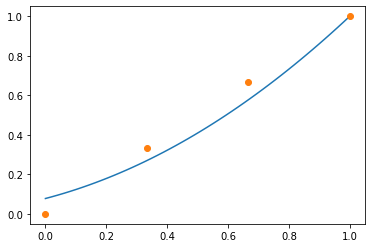

In [144]:
fig, ax = plt.subplots()
domain = np.linspace(0, 1, num=50)
ax.plot(domain, [func.cdf(x, *params) for x in domain])
ax.plot(counts_x, counts_y, 'o')

In [145]:
print(f"The best non-pathological fit is the `{func.name}` distribution with parameters {params}.")

The best non-pathological fit is the `triang` distribution with parameters (0.9999995032790814, -0.38730256734947843, 1.3873032751477359).


#### random weight function for generating graphs

In [161]:
def random_weight():
    # parameters for distribution computed in `labels_to_graph.ipynb`
    sample = st.triang.rvs(0.9999995032790814, -0.38730256734947843, 1.3873032751477359)
    return min(1, max(0, sample))